## Face and Facial Keypoint detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

In [2]:
ls images/

face_filter_ex.png   key_pts_example.png     mona_lisa.jpg  straw_hat.png
feature_map_ex.png   landmarks_numbered.jpg  moustache.png  sunglasses.png*
haar_cascade_ex.png  michelle_detected.png   obamas.jpg*    the_beatles.jpg


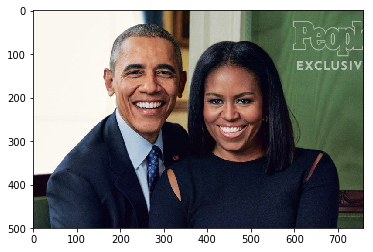

In [3]:
img = mpimg.imread('images/obamas.jpg')
img_copy = np.copy(img)
plt.imshow(img_copy)

In [4]:
model = cv2.dnn.readNetFromCaffe("face_detector/deploy.prototxt.txt", "face_detector/res10_300x300_ssd_iter_140000.caffemodel")

In [21]:
(h,w,_) = img_copy.shape
blob = cv2.dnn.blobFromImage(img_copy, 1.0,(300, 300), (104.0, 177.0, 123.0))
model.setInput(blob)
faces = model.forward()
number_of_faces = 0
for i in range(faces.shape[2]):
    confidence = faces[0, 0, i, 2]
    if confidence > .6:
        box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box.astype("int")
    
        cv2.rectangle(img_copy, (x1, y1), (x2, y2),(0, 0, 255), 2)
        number_of_faces +=1

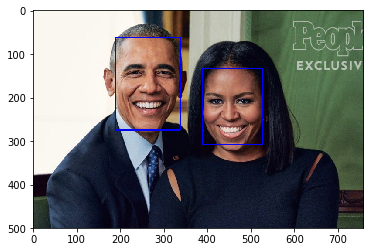

In [22]:
plt.imshow(img_copy)

In [23]:
import torch
import torchvision
from model import Net

net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model.pt',map_location=torch.device('cpu')))
net.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)

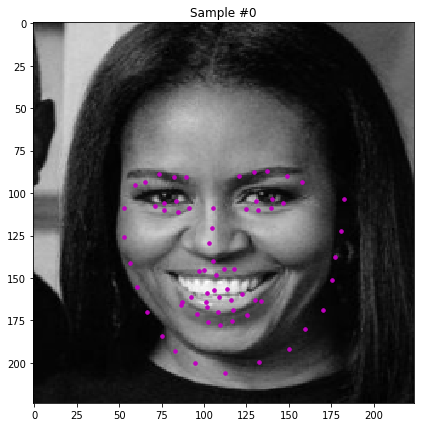

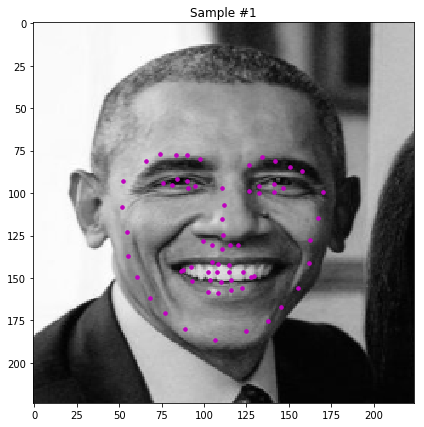

In [28]:
for i in range(faces.shape[2]):
    confidence = faces[0, 0, i, 2]
    if confidence > .6:
        box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box.astype("int")
        roi = img[y1-50:y2+50, x1-50:x2+50]
        roi = cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
        roi = roi/255.0
        roi = cv2.resize(roi,(224,224))
        roi_tensor = torch.from_numpy(roi.reshape([1,1,224,224]))
        roi_tensor = roi_tensor.type(torch.FloatTensor)
        output_pts = net(roi_tensor)
        torch.squeeze(output_pts)
        output_pts = output_pts.view(68, -1)
        predicted_key_pts = output_pts.data.numpy()  
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        plt.figure(figsize = (15,15))
        ax = plt.subplot(1, number_of_faces, i + 1)
        ax.set_title('Sample #{}'.format(i))
        plt.imshow(roi, cmap='gray')
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=50, marker='.', c='m')
plt.show()